In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from pycaret.classification import *

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## EDA dos acidentes e incidentes aéreos no Brasil

É possível investigar diversas análises tais como:

 - Análise de tendências: identificar padrões ou tendências em relação a tipos de acidentes, regiões, períodos de tempo, entre outros fatores relevantes;
 - Análise de risco: avaliar o risco de ocorrência de acidentes e incidentes aéreos em determinadas áreas ou situações;
 - Análise de desempenho: avaliar o desempenho de aeronaves, categoria da aviacao, tipo da operacao ou outras variáveis;

Essas análises possibilitam avaliar o custo-benefício de medidas de prevenção de acidentes e incidentes aéreos, construir modelos preditivos de risco de acidentes/incidentes baseado nas mais diversas caracteristicas.

### Leitura das bases

In [3]:
df_ocorrencias = pd.read_csv('dados/ocorrencia.csv')
df_ocorrencias.head()

,codigo_ocorrencia,classificacao,tipo,localidade,uf,pais,aerodromo,dia_ocorrencia,horario,sera_investigada,comando_investigador,status_investigacao,numero_relatorio,relatorio_publicado,dia_publicacao,quantidade_recomendacoes,aeronaves_envolvidas,saida_pista,dia_extracao
0,47965,ACIDENTE,FALHA DO MOTOR EM VOO,ARIQUEMES,RO,BRASIL,SJOG,2013-05-05,11:00:00,***,SERIPA-7,NaN,NaN,NaN,NaN,0,1,NaN,2016-07-30
1,50313,INCIDENTE GRAVE,POUSO SEM TREM,CACOAL,RO,BRASIL,SSKW,2013-11-25,12:32:00,SIM,SERIPA-7,FINALIZADA,IG-209/CENIPA/2013,1.0000,2014-04-07,0,1,NaN,2016-07-30
2,34078,ACIDENTE,PERDA DE CONTROLE NO SOLO,CEREJEIRAS,RO,BRASIL,****,2008-08-07,15:10:00,SIM,SERIPA-7,FINALIZADA,A - 517/CENIPA/2016,1.0000,2016-07-07,0,1,1.0000,2016-07-30
3,44988,ACIDENTE,POUSO LONGO,AMAJARI,RR,BRASIL,****,2011-08-11,17:00:00,SIM,SERIPA-7,FINALIZADA,A-105/CENIPA/2012,1.0000,2012-09-20,4,1,NaN,2016-07-30
4,38855,ACIDENTE,PERDA DE CONTROLE EM VOO,ACEGUÁ,RS,BRASIL,****,2009-12-28,17:30:00,SIM,SERIPA-5,ATIVA,A DEFINIR,NaN,NaN,0,1,NaN,2016-07-30


In [72]:
df_ocorrencias['codigo_ocorrencia'].nunique()

2027

In [4]:
df_ocorrencias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027 entries, 0 to 2026
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   codigo_ocorrencia         2027 non-null   int64  
 1   classificacao             2027 non-null   object 
 2   tipo                      2027 non-null   object 
 3   localidade                2027 non-null   object 
 4   uf                        2027 non-null   object 
 5   pais                      2027 non-null   object 
 6   aerodromo                 2024 non-null   object 
 7   dia_ocorrencia            2027 non-null   object 
 8   horario                   2027 non-null   object 
 9   sera_investigada          2027 non-null   object 
 10  comando_investigador      2027 non-null   object 
 11  status_investigacao       1821 non-null   object 
 12  numero_relatorio          1821 non-null   object 
 13  relatorio_publicado       995 non-null    float64
 14  dia_publ

In [5]:
df_ocorrencias.describe()

,codigo_ocorrencia,relatorio_publicado,quantidade_recomendacoes,aeronaves_envolvidas,saida_pista
count,2027.0000,995.0000,2027.0000,2027.0000,256.0000
mean,43942.8185,0.9940,1.1411,1.0079,0.9688
std,7863.3055,0.0775,3.5710,0.1039,0.1743
min,25799.0000,0.0000,0.0000,1.0000,0.0000
25%,38839.5000,1.0000,0.0000,1.0000,1.0000
50%,45554.0000,1.0000,0.0000,1.0000,1.0000
75%,50347.5000,1.0000,1.0000,1.0000,1.0000
max,65312.0000,1.0000,83.0000,4.0000,1.0000


In [6]:
df_aeronaves = pd.read_csv('dados/aeronave.csv')
df_aeronaves.head()

,codigo_aeronave,codigo_ocorrencia,matricula,codigo_operador,equipamento,fabricante,modelo,tipo_motor,quantidade_motores,peso_maximo_decolagem,quantidade_assentos,ano_fabricacao,pais_registro,categoria_registro,categoria_aviacao,origem_voo,destino_voo,fase_operacao,tipo_operacao,nivel_dano,quantidade_fatalidades,dia_extracao
0,4,45602,PPGXE,241,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,56-C,PISTÃO,1.0000,660,2.0000,1962.0000,BRASIL,PRI,INSTRUÇÃO,SDPW,SDPW,INDETERMINADA,INSTRUÇÃO,SUBSTANCIAL,NaN,2016-07-30
1,40,53551,PPGSZ,160,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,56-C,PISTÃO,1.0000,660,2.0000,1960.0000,BRASIL,PRI,INSTRUÇÃO,SBBP,SBBP,DECOLAGEM,INSTRUÇÃO,LEVE,NaN,2016-07-30
2,118,43721,PTCMT,1232,AVIÃO,BEECH AIRCRAFT,95-B55,PISTÃO,2.0000,2310,6.0000,1966.0000,BRASIL,TPX,TÁXI AÉREO,****,****,CORRIDA APÓS POUSO,TÁXI AÉREO,SUBSTANCIAL,NaN,2016-07-30
3,130,35556,PTEQI,3992,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-721C,PISTÃO,1.0000,1633,6.0000,1979.0000,BRASIL,TPP,PARTICULAR,SNDU,SBSL,CORRIDA APÓS POUSO,PRIVADA,LEVE,NaN,2016-07-30
4,191,32579,PPVMM,4365,AVIÃO,BOEING COMPANY,737-241,JATO,2.0000,52389,117.0000,1975.0000,BRASIL,TPR,REGULAR,****,****,SUBIDA,REGULAR,NENHUM,NaN,2016-07-30


In [73]:
df_aeronaves['codigo_aeronave'].nunique()

1871

In [7]:
df_aeronaves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   codigo_aeronave         2043 non-null   int64  
 1   codigo_ocorrencia       2043 non-null   int64  
 2   matricula               2043 non-null   object 
 3   codigo_operador         2043 non-null   int64  
 4   equipamento             2043 non-null   object 
 5   fabricante              2043 non-null   object 
 6   modelo                  2043 non-null   object 
 7   tipo_motor              2043 non-null   object 
 8   quantidade_motores      2034 non-null   float64
 9   peso_maximo_decolagem   2043 non-null   int64  
 10  quantidade_assentos     2025 non-null   float64
 11  ano_fabricacao          2039 non-null   float64
 12  pais_registro           2043 non-null   object 
 13  categoria_registro      2043 non-null   object 
 14  categoria_aviacao       2043 non-null   

In [8]:
df_aeronaves.describe()

,codigo_aeronave,codigo_ocorrencia,codigo_operador,quantidade_motores,peso_maximo_decolagem,quantidade_assentos,ano_fabricacao,quantidade_fatalidades
count,2043.0000,2043.0000,2043.0000,2034.0000,2043.0000,2025.0000,2039.0000,355.0000
mean,12300.6701,43961.8698,3156.4479,1.2443,5329.9442,8.9289,1902.4949,3.2085
std,7654.2687,7857.6587,1645.3511,0.4837,22004.5099,26.9223,402.0246,13.3671
min,4.0000,25799.0000,13.0000,0.0000,0.0000,0.0000,0.0000,1.0000
25%,9061.0000,38839.5000,1821.0000,1.0000,844.0000,2.0000,1975.0000,1.0000
50%,11267.0000,45564.0000,3992.0000,1.0000,1633.0000,4.0000,1986.0000,2.0000
75%,13601.5000,50353.5000,3992.0000,2.0000,2155.0000,6.0000,1999.0000,2.0000
max,39147.0000,65312.0000,6270.0000,4.0000,285990.0000,301.0000,2015.0000,199.0000


Com a rápida avaliação das estatisticas descritivas podemos identificar alguns pontos importantes a serem considerados no decorrer da análise:
 - Nem todas as ocorrências possuem relatórios publicados;
 - Ocorrências com no mínimo 1 e no máximo 4 aeronaves;
 - Aeronaves com o campo de quantidade de motores nulos e 0;
 - Aeronaves com o campo de peso máximo para a decolagem 0;
 - Aeronaves com o campo de quantidade de assentos nulos e 0;
 - Aeronaves com o campo do ano de fabricação nulos e 0;
 - Os nulos da coluna quantidade_fatalidades devem ser substituidos por 0;
 - Os nulos da coluna saida_pista devem ser substituidos por 0.


### Explorando a inconsistências das colunas

In [9]:
# Aeronaves com o campo de quantidade de motores 0
df_aeronaves[(df_aeronaves['quantidade_motores']==0) | (df_aeronaves['quantidade_motores'].isna()) & (df_aeronaves['equipamento']!='PLANADOR')]

,codigo_aeronave,codigo_ocorrencia,matricula,codigo_operador,equipamento,fabricante,modelo,tipo_motor,quantidade_motores,peso_maximo_decolagem,quantidade_assentos,ano_fabricacao,pais_registro,categoria_registro,categoria_aviacao,origem_voo,destino_voo,fase_operacao,tipo_operacao,nivel_dano,quantidade_fatalidades,dia_extracao
25,445,43725,PTPKD,161,PLANADOR,INDÚSTRIA PARANAENSE DE ESTRUTURAS,KW1,SEM TRAÇÃO,0.0000,280,1.0000,1983.0000,BRASIL,PRI,INSTRUÇÃO,SWFR,SWFR,CORRIDA APÓS POUSO,INSTRUÇÃO,SUBSTANCIAL,NaN,2016-07-30
375,6370,51653,PTPJX,2361,PLANADOR,INDÚSTRIA PARANAENSE DE ESTRUTURAS,KW1,SEM TRAÇÃO,0.0000,280,1.0000,1983.0000,BRASIL,PRI,INSTRUÇÃO,SSAK,SSAK,DECOLAGEM,INSTRUÇÃO,SUBSTANCIAL,NaN,2016-07-30
545,9155,27356,PTPPE,161,PLANADOR,LET AIRCRAFT INDUSTRIES,L23,SEM TRAÇÃO,0.0000,509,2.0000,1993.0000,BRASIL,PRI,INSTRUÇÃO,****,****,RETA FINAL,INSTRUÇÃO,***,NaN,2016-07-30
563,9188,27932,PPXMJ,6270,AVIÃO,EMBRAER,EMB-195,***,0.0000,0,0.0000,0.0000,BRASIL,PET,EXPERIMENTAL,****,****,INDETERMINADA,EXPERIMENTAL,SUBSTANCIAL,NaN,2016-07-30
610,9258,29555,PPFII,204,PLANADOR,INDÚSTRIA PARANAENSE DE ESTRUTURAS,IPE-02B,SEM TRAÇÃO,0.0000,565,2.0000,1988.0000,BRASIL,PRI,INSTRUÇÃO,****,****,INDETERMINADA,INSTRUÇÃO,DESTRUÍDA,2.0000,2016-07-30
727,9529,32655,PPFJS,231,PLANADOR,INDÚSTRIA PARANAENSE DE ESTRUTURAS,IPE-02B,SEM TRAÇÃO,0.0000,565,2.0000,1989.0000,BRASIL,PRI,INSTRUÇÃO,SSNH,SSNH,RETA FINAL,INSTRUÇÃO,SUBSTANCIAL,NaN,2016-07-30
749,9605,34016,N525ZS,3992,AVIÃO,BEECH AIRCRAFT,100,PISTÃO,0.0000,5871,0.0000,1971.0000,ESTADOS UNIDOS,TPP,PARTICULAR,****,****,DECOLAGEM,***,DESTRUÍDA,1.0000,2016-07-30
781,9673,34555,N400SA,3992,AVIÃO,BEECH AIRCRAFT,58,PISTÃO,0.0000,2495,0.0000,1987.0000,ESTADOS UNIDOS,TPP,PARTICULAR,****,****,CRUZEIRO,***,DESTRUÍDA,4.0000,2016-07-30
834,9872,36056,PTPFO,244,PLANADOR,INDÚSTRIA PARANAENSE DE ESTRUTURAS,KW1,SEM TRAÇÃO,0.0000,280,1.0000,1980.0000,BRASIL,PRI,INSTRUÇÃO,****,****,DECOLAGEM,INSTRUÇÃO,SUBSTANCIAL,NaN,2016-07-30
1152,12141,44233,PRCRZ,3992,AVIÃO,PIPER AIRCRAFT,PA-WNE,***,0.0000,1315,0.0000,0.0000,BRASIL,TPP,PARTICULAR,****,****,POUSO,PRIVADA,LEVE,NaN,2016-07-30


In [10]:
# tentando substituir a quantidade de motores dentro da base, buscando inicialmente pelo fabricante/modelo e em seguida substituindo pela média do fabricante e por último pela média do tipo de equipamento:
for idx, row in df_aeronaves[(df_aeronaves['quantidade_motores']==0) & (df_aeronaves['equipamento']!='PLANADOR')  | (df_aeronaves['quantidade_motores'].isna())].iterrows():
    print(f"{row['fabricante']} - {row['modelo']}")
    mean_qtd_motores =  round(df_aeronaves.loc[(df_aeronaves['quantidade_motores']!=0) & (df_aeronaves['fabricante']==row['fabricante']) & (df_aeronaves['modelo']==row['modelo']),'quantidade_motores'].mean(),0)
    if np.isnan(mean_qtd_motores):
        mean_qtd_motores =  round(df_aeronaves.loc[(df_aeronaves['quantidade_motores']!=0) & (df_aeronaves['fabricante']==row['fabricante']),'quantidade_motores'].mean(),0)
        if np.isnan(mean_qtd_motores):
            mean_qtd_motores =  round(df_aeronaves.loc[(df_aeronaves['quantidade_motores']!=0) & (df_aeronaves['equipamento']==row['equipamento']),'quantidade_motores'].mean(),0)
            
    print(mean_qtd_motores)
        
    df_aeronaves.loc[(df_aeronaves['fabricante']==row['fabricante']) & (df_aeronaves['modelo']==row['modelo']) &\
                        (df_aeronaves['codigo_ocorrencia']==row['codigo_ocorrencia']) & (df_aeronaves['codigo_aeronave']==row['codigo_aeronave']) ,
                        'quantidade_motores'] = mean_qtd_motores        

EMBRAER - EMB-195
2.0
BEECH AIRCRAFT - 100
2.0
BEECH AIRCRAFT - 58
2.0
PIPER AIRCRAFT - PA-WNE
1.0
FABRICACAO PROPRIA - ***
1.0
FABRICACAO PROPRIA - CMA
1.0
*** - SEAWIND AVIAO
1.0
PIPER AIRCRAFT - PA-34-200T
2.0
*** - PITTSS15 AVIAO
1.0
*** - P64B
1.0
*** - ***
1.0
*** - ***
1.0
*** - ***
1.0
*** - ***
1.0
*** - ***
1.0
*** - ***
1.0
*** - ***
1.0
CESSNA AIRCRAFT - A-37B
1.0
MCDONNELL DOUGLAS - MD82
3.0
CESSNA AIRCRAFT - T210L
1.0
CESSNA AIRCRAFT - N210
1.0
*** - ***
1.0
CESSNA AIRCRAFT - 210R
1.0
CESSNA AIRCRAFT - 210D
1.0
*** - ***
1.0
*** - ***
1.0
*** - ***
1.0
*** - ***
1.0
WZQ-OKECIE - PZL 106 KRUK
1.0


In [11]:
# Aeronaves com o campo de quantidade de motores 0
df_aeronaves[(df_aeronaves['quantidade_motores']==0) & (df_aeronaves['equipamento']!='PLANADOR') | (df_aeronaves['quantidade_motores'].isna())]

,codigo_aeronave,codigo_ocorrencia,matricula,codigo_operador,equipamento,fabricante,modelo,tipo_motor,quantidade_motores,peso_maximo_decolagem,quantidade_assentos,ano_fabricacao,pais_registro,categoria_registro,categoria_aviacao,origem_voo,destino_voo,fase_operacao,tipo_operacao,nivel_dano,quantidade_fatalidades,dia_extracao


In [12]:
# avaliando peso_maximo de decolagem zerados
df_aeronaves[(df_aeronaves['peso_maximo_decolagem']==0)]

,codigo_aeronave,codigo_ocorrencia,matricula,codigo_operador,equipamento,fabricante,modelo,tipo_motor,quantidade_motores,peso_maximo_decolagem,quantidade_assentos,ano_fabricacao,pais_registro,categoria_registro,categoria_aviacao,origem_voo,destino_voo,fase_operacao,tipo_operacao,nivel_dano,quantidade_fatalidades,dia_extracao
369,6283,51437,PPZZZ,3992,AVIÃO,FABRICACAO PROPRIA,RANS S-10-AVIAO,PISTÃO,1.0000,0,0.0000,0.0000,BRASIL,PET,EXPERIMENTAL,****,****,MANOBRA,EXPERIMENTAL,NENHUM,NaN,2016-07-30
563,9188,27932,PPXMJ,6270,AVIÃO,EMBRAER,EMB-195,***,2.0000,0,0.0000,0.0000,BRASIL,PET,EXPERIMENTAL,****,****,INDETERMINADA,EXPERIMENTAL,SUBSTANCIAL,NaN,2016-07-30
657,9360,30879,PRAAH,4675,AVIÃO,AIR TRACTOR,AT-401B,PISTÃO,1.0000,0,1.0000,2003.0000,BRASIL,SAE-AG,AGRÍCOLA,****,****,ESPECIALIZADA,AGRÍCOLA,LEVE,NaN,2016-07-30
1005,11136,41729,PUHRJ,3992,ULTRALEVE,FABRICACAO PROPRIA,TRIKE,PISTÃO,1.0000,0,0.0000,0.0000,BRASIL,PET,EXPERIMENTAL,****,****,NAVEGAÇÃO A BAIXA ALTURA,EXPERIMENTAL,DESTRUÍDA,2.0000,2016-07-30
1115,11833,43729,BRXXX1,1657,AVIÃO,CESSNA AIRCRAFT,R182,PISTÃO,1.0000,0,0.0000,0.0000,NÃO IDENTIFICADO,***,***,****,****,INDETERMINADA,***,DESTRUÍDA,NaN,2016-07-30
1399,13132,46153,PUJGA,3992,ULTRALEVE,FABRICACAO PROPRIA,EXPERIMENT,PISTÃO,1.0000,0,0.0000,0.0000,BRASIL,PET,EXPERIMENTAL,****,****,DECOLAGEM,EXPERIMENTAL,DESTRUÍDA,2.0000,2016-07-30
1496,13497,51435,PUXXX1,1657,ULTRALEVE,MAULE AIRCRAFT,ULTRALEVE,PISTÃO,1.0000,0,0.0000,0.0000,BRASIL,PET,EXPERIMENTAL,****,****,DECOLAGEM,EXPERIMENTAL,DESTRUÍDA,1.0000,2016-07-30
1497,13497,46780,PUXXX1,3992,ULTRALEVE,MAULE AIRCRAFT,ULTRALEVE,PISTÃO,1.0000,0,0.0000,0.0000,BRASIL,PEX,EXPERIMENTAL,****,****,APROXIMAÇÃO FINAL,EXPERIMENTAL,DESTRUÍDA,1.0000,2016-07-30
1498,13497,53192,PUXXX1,3992,ULTRALEVE,MAULE AIRCRAFT,ULTRALEVE,PISTÃO,1.0000,0,0.0000,0.0000,BRASIL,PET,EXPERIMENTAL,SDNY,SNAU,INDETERMINADA,PRIVADA,DESTRUÍDA,1.0000,2016-07-30
1507,13527,46845,PUIMG,3992,ULTRALEVE,FABRICACAO PROPRIA,***,***,1.0000,0,0.0000,0.0000,BRASIL,PET,EXPERIMENTAL,****,****,NAVEGAÇÃO A BAIXA ALTURA,EXPERIMENTAL,SUBSTANCIAL,2.0000,2016-07-30


In [13]:
# tentando substituir o peso máximo de decolagem zerados com valores de dentro da base, buscando inicialmente pelo fabricante/modelo e em seguida substituindo pela média do fabricante e por último pela média do tipo de equipamento:
for idx, row in df_aeronaves[(df_aeronaves['peso_maximo_decolagem']==0)].iterrows():
    print(f"{row['fabricante']} - {row['modelo']}")
    mean_peso_maximo_decolagem =  round(df_aeronaves.loc[(df_aeronaves['peso_maximo_decolagem']!=0) & (df_aeronaves['fabricante']==row['fabricante']) & (df_aeronaves['modelo']==row['modelo']),'peso_maximo_decolagem'].mean(),0)
    if np.isnan(mean_peso_maximo_decolagem):
        mean_peso_maximo_decolagem =  round(df_aeronaves.loc[(df_aeronaves['peso_maximo_decolagem']!=0) & (df_aeronaves['fabricante']==row['fabricante']),'peso_maximo_decolagem'].mean(),0)
        if np.isnan(mean_peso_maximo_decolagem):
            mean_peso_maximo_decolagem =  round(df_aeronaves.loc[(df_aeronaves['peso_maximo_decolagem']!=0) & (df_aeronaves['equipamento']==row['equipamento']),'peso_maximo_decolagem'].mean(),0)
    print(mean_peso_maximo_decolagem)
        
    df_aeronaves.loc[(df_aeronaves['fabricante']==row['fabricante']) & (df_aeronaves['modelo']==row['modelo']) &\
                        (df_aeronaves['codigo_ocorrencia']==row['codigo_ocorrencia']) & (df_aeronaves['codigo_aeronave']==row['codigo_aeronave']) ,
                        'peso_maximo_decolagem'] = mean_peso_maximo_decolagem   

FABRICACAO PROPRIA - RANS S-10-AVIAO
417.0
EMBRAER - EMB-195
4446.0
AIR TRACTOR - AT-401B
2722.0
FABRICACAO PROPRIA - TRIKE
417.0
CESSNA AIRCRAFT - R182
1406.0
FABRICACAO PROPRIA - EXPERIMENT
417.0
MAULE AIRCRAFT - ULTRALEVE
881.0
MAULE AIRCRAFT - ULTRALEVE
881.0
MAULE AIRCRAFT - ULTRALEVE
881.0
FABRICACAO PROPRIA - ***
417.0
FABRICACAO PROPRIA - CMA
417.0
FABRICACAO PROPRIA - EXPERIMENT
417.0
EXTRA-FLUGZEUGBAU - EA 300/L
6438.0
FABRICACAO PROPRIA - EXPERIMENT
417.0
*** - SEAWIND AVIAO
643.0
*** - PITTSS15 AVIAO
643.0
*** - ***
353.0
*** - ***
353.0
*** - ***
353.0
*** - ***
353.0
*** - ***
353.0
*** - ***
353.0
CESSNA AIRCRAFT - A-37B
1881.0
BOEING COMPANY - 767-3P6
79493.0
BOEING COMPANY - 747-312M
79493.0
*** - ***
353.0
*** - ***
353.0
*** - ***
353.0
PIPER AIRCRAFT - PA34
1716.0


In [14]:
# avaliando peso_maximo de decolagem zerados
df_aeronaves[(df_aeronaves['peso_maximo_decolagem']==0) | (df_aeronaves['peso_maximo_decolagem'].isna())]

,codigo_aeronave,codigo_ocorrencia,matricula,codigo_operador,equipamento,fabricante,modelo,tipo_motor,quantidade_motores,peso_maximo_decolagem,quantidade_assentos,ano_fabricacao,pais_registro,categoria_registro,categoria_aviacao,origem_voo,destino_voo,fase_operacao,tipo_operacao,nivel_dano,quantidade_fatalidades,dia_extracao


In [15]:
df_aeronaves[(df_aeronaves['quantidade_assentos']==0) | (df_aeronaves['quantidade_assentos'].isna())].describe()

,codigo_aeronave,codigo_ocorrencia,codigo_operador,quantidade_motores,peso_maximo_decolagem,quantidade_assentos,ano_fabricacao,quantidade_fatalidades
count,101.0000,101.0000,101.0000,101.0000,101.0000,83.0000,98.0000,26.0000
mean,25280.2970,47004.1485,4010.5941,1.4059,24141.8020,0.0000,731.1429,1.7308
std,10640.8040,7287.0338,1190.2377,0.7096,65210.8390,0.0000,964.5048,1.0792
min,6283.0000,27633.0000,193.0000,0.0000,208.0000,0.0000,0.0000,1.0000
25%,13497.0000,43869.0000,3992.0000,1.0000,600.0000,0.0000,0.0000,1.0000
50%,31810.0000,49154.0000,3992.0000,1.0000,1633.0000,0.0000,0.0000,1.0000
75%,34598.0000,52834.0000,3992.0000,2.0000,3000.0000,0.0000,1978.0000,2.0000
max,39147.0000,60879.0000,6270.0000,4.0000,285990.0000,0.0000,2015.0000,4.0000


In [16]:
# tentando substituir a quantidade_assentos zerados com valores de dentro da base, buscando inicialmente pelo fabricante/modelo e em seguida substituindo pela média do fabricante ou média do tipo de equipamento:
for idx, row in df_aeronaves[(df_aeronaves['quantidade_assentos']==0) | (df_aeronaves['quantidade_assentos'].isna())].iterrows():
    print(f"{row['fabricante']} - {row['modelo']}")
    mean_quantidade_assentos =  round(df_aeronaves.loc[(df_aeronaves['quantidade_assentos']!=0) & (df_aeronaves['fabricante']==row['fabricante']) & (df_aeronaves['modelo']==row['modelo']),'quantidade_assentos'].mean(),0)
    if np.isnan(mean_quantidade_assentos):
        mean_quantidade_assentos =  round(df_aeronaves.loc[(df_aeronaves['quantidade_assentos']!=0) & (df_aeronaves['fabricante']==row['fabricante']),'quantidade_assentos'].mean(),0)
        if np.isnan(mean_quantidade_assentos):
            mean_quantidade_assentos =  round(df_aeronaves.loc[(df_aeronaves['quantidade_assentos']!=0) & (df_aeronaves['equipamento']==row['equipamento']),'quantidade_assentos'].mean(),0) 
    print(mean_quantidade_assentos)

    df_aeronaves.loc[(df_aeronaves['fabricante']==row['fabricante']) & (df_aeronaves['modelo']==row['modelo']) &\
                        (df_aeronaves['codigo_ocorrencia']==row['codigo_ocorrencia']) & (df_aeronaves['codigo_aeronave']==row['codigo_aeronave']) ,
                        'quantidade_assentos'] = mean_quantidade_assentos   

FABRICACAO PROPRIA - RANS S-10-AVIAO
11.0
EMBRAER - EMB-195
10.0
BEECH AIRCRAFT - 100
6.0
BEECH AIRCRAFT - 58
6.0
PIPER AIRCRAFT - PA-23
4.0
BEECH AIRCRAFT - A35
6.0
CESSNA AIRCRAFT - 210
5.0
PIPER AIRCRAFT - PA-42
4.0
FABRICACAO PROPRIA - TRIKE
11.0
FLYER INDUSTRIA AERONAUTICA LTDA - RV6
2.0
CESSNA AIRCRAFT - 210
5.0
CESSNA AIRCRAFT - R182
4.0
BEECH AIRCRAFT - A36
6.0
FABRICACAO PROPRIA - FOX V5 SUPER
11.0
CESSNA AIRCRAFT - 210L
6.0
PIPER AIRCRAFT - PA-34-220T
6.0
PIPER AIRCRAFT - PA-WNE
4.0
CESSNA AIRCRAFT - 150M
2.0
EMBRAER - EMB-505
10.0
CESSNA AIRCRAFT - 210N
6.0
EMBRAER - EMB-505
10.0
FABRICACAO PROPRIA - EXPERIMENT
11.0
BEECH AIRCRAFT - 58
6.0
MAULE AIRCRAFT - ULTRALEVE
5.0
MAULE AIRCRAFT - ULTRALEVE
5.0
MAULE AIRCRAFT - ULTRALEVE
5.0
FABRICACAO PROPRIA - ***
11.0
CESSNA AIRCRAFT - 152
2.0
PIPER AIRCRAFT - PA-34-200
6.0
FABRICACAO PROPRIA - CMA
11.0
FABRICACAO PROPRIA - EXPERIMENT
11.0
CESSNA AIRCRAFT - 210
5.0
*** - AGUIA JA
2.0
EXTRA-FLUGZEUGBAU - EA 300/L
11.0
FABRICACAO PROP

In [17]:
df_aeronaves[(df_aeronaves['quantidade_assentos']==0) | (df_aeronaves['quantidade_assentos'].isna())]

,codigo_aeronave,codigo_ocorrencia,matricula,codigo_operador,equipamento,fabricante,modelo,tipo_motor,quantidade_motores,peso_maximo_decolagem,quantidade_assentos,ano_fabricacao,pais_registro,categoria_registro,categoria_aviacao,origem_voo,destino_voo,fase_operacao,tipo_operacao,nivel_dano,quantidade_fatalidades,dia_extracao


In [18]:
# analisando o ano de fabricação zerados e nulos
df_aeronaves[(df_aeronaves['ano_fabricacao']<100) | (df_aeronaves['ano_fabricacao'].isna())].describe()

,codigo_aeronave,codigo_ocorrencia,codigo_operador,quantidade_motores,peso_maximo_decolagem,quantidade_assentos,ano_fabricacao,quantidade_fatalidades
count,91.0000,91.0000,91.0000,91.0000,91.0000,91.0000,87.0000,23.0000
mean,21607.0440,45290.6374,3722.7473,1.3297,23434.0659,22.6264,0.0000,1.5217
std,11515.0212,7608.5126,1352.4360,0.6840,66164.5704,51.4640,0.0000,0.6653
min,1629.0000,26621.0000,120.0000,0.0000,250.0000,1.0000,0.0000,1.0000
25%,11632.5000,42047.0000,3992.0000,1.0000,643.0000,2.0000,0.0000,1.0000
50%,15090.0000,46307.0000,3992.0000,1.0000,1361.0000,5.0000,0.0000,1.0000
75%,34552.0000,51634.5000,3992.0000,1.5000,1962.5000,8.0000,0.0000,2.0000
max,39147.0000,60879.0000,6270.0000,4.0000,285990.0000,190.0000,0.0000,3.0000


In [19]:
# tentando substituir o ano_fabricacao zerados com valores de dentro da base, buscando inicialmente pelo fabricante/modelo e em seguida substituindo pela média do fabricante ou média do tipo de equipamento:
for idx, row in df_aeronaves[(df_aeronaves['ano_fabricacao']==0) | (df_aeronaves['ano_fabricacao'].isna())].iterrows():
    print(f"{row['fabricante']} - {row['modelo']}")
    mean_ano_fabricacao =  round(df_aeronaves.loc[(df_aeronaves['ano_fabricacao']!=0) & (df_aeronaves['fabricante']==row['fabricante']) & (df_aeronaves['modelo']==row['modelo']),'ano_fabricacao'].mean(),0)
    if np.isnan(mean_ano_fabricacao):
        mean_ano_fabricacao =  round(df_aeronaves.loc[(df_aeronaves['ano_fabricacao']!=0) & (df_aeronaves['fabricante']==row['fabricante']),'ano_fabricacao'].mean(),0)
        if np.isnan(mean_ano_fabricacao):
            mean_ano_fabricacao =  round(df_aeronaves.loc[(df_aeronaves['ano_fabricacao']!=0) & (df_aeronaves['equipamento']==row['equipamento']),'ano_fabricacao'].mean(),0) 
    print(mean_ano_fabricacao)

    df_aeronaves.loc[(df_aeronaves['fabricante']==row['fabricante']) & (df_aeronaves['modelo']==row['modelo']) &\
                        (df_aeronaves['codigo_ocorrencia']==row['codigo_ocorrencia']) & (df_aeronaves['codigo_aeronave']==row['codigo_aeronave']) ,
                        'ano_fabricacao'] = mean_ano_fabricacao  

NEIVA INDUSTRIA AERONAUTICA - EMB-201A
1983.0
NEIVA INDUSTRIA AERONAUTICA - EMB-200A
1974.0
NEIVA INDUSTRIA AERONAUTICA - EMB-201
1976.0
FABRICACAO PROPRIA - RANS S-10-AVIAO
1984.0
NEIVA INDUSTRIA AERONAUTICA - EMB-710C
1976.0
NEIVA INDUSTRIA AERONAUTICA - EMB-201A
1983.0
HELIBRAS - HB-350B
1985.0
EMBRAER - EMB-195
1989.0
CESSNA AIRCRAFT - 210L
1974.0
CESSNA AIRCRAFT - 182C
1977.0
AGUSTA - A109S
2006.0
CESSNA AIRCRAFT - 182P
1974.0
CESSNA AIRCRAFT - 182P
1974.0
NEIVA INDUSTRIA AERONAUTICA - EMB-711ST
1982.0
BOEING COMPANY - 727-2J7
1992.0
CIA AERONAUTICA PAULISTA - CAP-4
1946.0
CESSNA AIRCRAFT - 210
1977.0
PIPER AIRCRAFT - PA-42
1979.0
NEIVA INDUSTRIA AERONAUTICA - EMB-712
1982.0
FABRICACAO PROPRIA - TRIKE
1984.0
FLYER INDUSTRIA AERONAUTICA LTDA - RV6
2005.0
PIPER AIRCRAFT - PA-28-235
1975.0
CESSNA AIRCRAFT - 210
1977.0
BEECH AIRCRAFT - C90A
1996.0
CESSNA AIRCRAFT - R182
1979.0
BEECH AIRCRAFT - A36
1981.0
FABRICACAO PROPRIA - FOX V5 SUPER
1984.0
CESSNA AIRCRAFT - 210L
1974.0
PIPER AIRC

#### Preenchendo os valores nulos
 - Os nulos da coluna quantidade_fatalidades devem ser substituidos por 0;
 - Os nulos da coluna saida_pista devem ser substituidos por 0.

In [20]:
df_aeronaves['quantidade_fatalidades'].fillna(0, inplace=True)
df_ocorrencias['saida_pista'].fillna(0, inplace=True)

In [21]:
df_ocorrencias.describe()

,codigo_ocorrencia,relatorio_publicado,quantidade_recomendacoes,aeronaves_envolvidas,saida_pista
count,2027.0000,995.0000,2027.0000,2027.0000,2027.0000
mean,43942.8185,0.9940,1.1411,1.0079,0.1223
std,7863.3055,0.0775,3.5710,0.1039,0.3278
min,25799.0000,0.0000,0.0000,1.0000,0.0000
25%,38839.5000,1.0000,0.0000,1.0000,0.0000
50%,45554.0000,1.0000,0.0000,1.0000,0.0000
75%,50347.5000,1.0000,1.0000,1.0000,0.0000
max,65312.0000,1.0000,83.0000,4.0000,1.0000


In [22]:
df_aeronaves.describe()

,codigo_aeronave,codigo_ocorrencia,codigo_operador,quantidade_motores,peso_maximo_decolagem,quantidade_assentos,ano_fabricacao,quantidade_fatalidades
count,2043.0000,2043.0000,2043.0000,2043.0000,2043.0000,2043.0000,2043.0000,2043.0000
mean,12300.6701,43961.8698,3156.4479,1.2560,5421.7797,10.0259,1987.3324,0.5575
std,7654.2687,7857.6587,1645.3511,0.4700,22123.2951,29.1672,15.2699,5.6969
min,4.0000,25799.0000,13.0000,0.0000,208.0000,1.0000,1936.0000,0.0000
25%,9061.0000,38839.5000,1821.0000,1.0000,850.0000,2.0000,1976.0000,0.0000
50%,11267.0000,45564.0000,3992.0000,1.0000,1633.0000,4.0000,1987.0000,0.0000
75%,13601.5000,50353.5000,3992.0000,2.0000,2155.0000,6.0000,2000.0000,0.0000
max,39147.0000,65312.0000,6270.0000,4.0000,285990.0000,301.0000,2015.0000,199.0000


Como pode-se observar foi efetivo o tratamento proposto, todas as inconsistências foram corrigidas sem a perda de dados.
É importante destacar que caso fosse uma análise com propositos reais esse tratamentos deveria ser avaliado por uma equipe com conhecimento do setor aereo, uma vez que suposições erroneas podem gerar resultados equivocados.

### Explorando Aeronaves

Avaliando a distribuição e frequência das variáveis:

#### Avaliando as caracteristicas dos Acidentes/Incidentes por tipo de equipamento

In [23]:
fig = px.histogram(df_aeronaves, x='equipamento', nbins=20)
fig.update_layout(
    height=700,
    width=1500,
    title=dict(
        text='<b>Frequência dos Equipamentos para os Acidentes/Incidentes</b>',
        x=0.5,
        y=0.95,
        font=dict(
            family="Arial",
            size=40,
            color='#000000'
        )
    ),
    xaxis_title="<b>Equipamento</b>",
    yaxis_title='<b>Quant. Acidentes/Incidentes</b>',
    font=dict(
        family="Courier New, Monospace",
        size=24,
        color='#000000'
    ),
    xaxis={'categoryorder':'total descending'}
    
)
fig.show()

Aqui é apresentado que os equipamentos com mais acidentes/incidentes são aviões. Com isso vamos continuar explorando esse tipo.

In [24]:
df_aeronaves_aviao = df_aeronaves[df_aeronaves['equipamento']=='AVIÃO']

In [25]:
df_aeronaves_aviao['codigo_aeronave'].value_counts().reset_index().sort_values(by='codigo_aeronave', ascending=False)

,index,codigo_aeronave
0,1297,4
2,5118,4
3,9352,4
4,9054,4
1,10000,4
...,...,...
567,25629,1
566,25652,1
565,25675,1
564,25823,1


In [26]:
fig = px.histogram(df_aeronaves_aviao['codigo_aeronave'].value_counts().reset_index().sort_values(by='codigo_aeronave', ascending=False), x='codigo_aeronave', nbins=10)
fig.update_layout(
    height=500,
    width=1000,
    title=dict(
        text='<b>Frequência de Aviões em Acidentes/Incidentes</b>',
        x=0.5,
        y=0.95,
        font=dict(
            family="Arial",
            size=40,
            color='#000000'
        )
    ),
    xaxis_title="<b>Freq. Aeronave</b>",
    yaxis_title='<b>Quant. Acidentes/Incidentes</b>',
    font=dict(
        family="Courier New, Monospace",
        size=24,
        color='#000000'
    )
)
fig.show()

In [27]:
df_aeronaves_aviao['codigo_aeronave'].value_counts().reset_index().sort_values(by='codigo_aeronave', ascending=False).head(6)

,index,codigo_aeronave
0,1297,4
2,5118,4
3,9352,4
4,9054,4
1,10000,4
9,3424,3


A base de dados apresenta no máxima 4 ocorrencias de acidentes/incidentes para uma mesma aeronave e temos apenas 5 aeronaves com essa frequência.

In [28]:
# avaliando os operadores
fig = px.histogram(df_aeronaves_aviao['codigo_operador'].astype(str), x='codigo_operador', nbins=10)
fig.update_layout(
    height=700,
    width=2100,
    title=dict(
        text='<b>Frequência dos Operadores para os Acidentes/Incidentes</b>',
        x=0.5,
        y=0.95,
        font=dict(
            family="Arial",
            size=40,
            color='#000000'
        )
    ),
    xaxis_title="<b>Operadores</b>",
    yaxis_title='<b>Quant. Acidentes/Incidentes</b>',
    font=dict(
        family="Courier New, Monospace",
        size=24,
        color='#000000'
    ),
    xaxis={'categoryorder':'total descending'}
)
fig.show()

O operador 3992 é o mais frequente nas ocorrências. Isso deve ser explorado para verificar a causa

In [29]:
# avaliando os operadores
fig = px.histogram(df_aeronaves_aviao['fabricante'].astype(str), x='fabricante', nbins=10)
fig.update_layout(
    height=1100,
    width=2000,
    title=dict(
        text='<b>Frequência dos Fabricantes para os Acidentes/Incidentes</b>',
        x=0.5,
        y=0.95,
        font=dict(
            family="Arial",
            size=40,
            color='#000000'
        )
    ),
    xaxis_title="<b>Fabricante</b>",
    yaxis_title='<b>Quant. Acidentes/Incidentes</b>',
    font=dict(
        family="Courier New, Monospace",
        size=20,
        color='#000000'
    ),
    xaxis={'categoryorder':'total descending'}
)
fig.show()

Aqui podemos ver que os acidentes/incidentes se concentram em 7 Fabricates. 

#### Avaliando a categoria da aviação

In [30]:
# avaliando os operadores
fig = px.histogram(df_aeronaves_aviao['categoria_aviacao'].astype(str), x='categoria_aviacao', nbins=10)
fig.update_layout(
    height=1100,
    width=2000,
    title=dict(
        text='<b>Frequência das Categoria da Aviação nos Acidentes/Incidentes</b>',
        x=0.5,
        y=0.95,
        font=dict(
            family="Arial",
            size=40,
            color='#000000'
        )
    ),
    xaxis_title="<b>Categoria da Aviação</b>",
    yaxis_title='<b>Quant. Acidentes/Incidentes</b>',
    font=dict(
        family="Courier New, Monospace",
        size=20,
        color='#000000'
    ),
    xaxis={'categoryorder':'total descending'}
)
fig.show()

Existem 4 categorias da aviação com mais incidencia de acidentes.

In [75]:
df_aeronaves_aviao['qtd_ocorrencias'] = 1
fig = px.treemap(df_aeronaves_aviao, path=['codigo_operador','tipo_operacao'], values='qtd_ocorrencias',
                  color='fabricante', 
                #   hover_data=['iso_alpha'],
                  color_continuous_scale='RdBu',
                #   color_continuous_midpoint=np.average(df_aeronaves_aviao['quantidade_fatalidades'], weights=df_aeronaves_aviao['qtd_ocorrencias'])
                # textinfo = "label+value+percent parent+percent entry+percent root",
                  )

fig.data[0].textinfo ="label+value+percent parent+percent entry+percent root"
fig.update_layout(
        height=1100,
        width=2000,
        title=dict(
            text=f"<b> Relação entre Operadores, Fabricantes e Tipo de operação nos Acidentes/Incidentes</b>",
            x=0.5,
            y=0.95,
            font=dict(
                family="Arial",
                size=40,
                color='#000000'
            )
        ),
       
        font=dict(
            family="Courier New, Monospace",
            size=20,
            color='#000000'
        ),
        xaxis={'categoryorder':'total descending'}
    )
fig.show()

### Avaliando as ocrrencias quanto a fase da operacao da aeronave,	tipo da operacao da aeronave, nivel de dano e a	quantidade de fatalidades por categoria da aviação e global

In [31]:
#avaliação global
for col in ['fase_operacao','tipo_operacao','nivel_dano','nivel_dano']:
    # avaliando os operadores
    fig = px.histogram(df_aeronaves_aviao, x=col, nbins=100)
    fig.update_layout(
        height=1100,
        width=2000,
        title=dict(
            text=f"<b>Frequência {col.replace('_',' ').capitalize()} nos Acidentes/Incidentes</b>",
            x=0.5,
            y=0.95,
            font=dict(
                family="Arial",
                size=40,
                color='#000000'
            )
        ),
        xaxis_title=f"<b>{col.replace('_',' ').capitalize()}</b>",
        yaxis_title='<b>Quant. Acidentes/Incidentes</b>',
        font=dict(
            family="Courier New, Monospace",
            size=20,
            color='#000000'
        ),
        xaxis={'categoryorder':'total descending'}
    )
    fig.show()

In [32]:
#avaliação global
for col in ['fase_operacao','tipo_operacao','nivel_dano','quantidade_fatalidades']:
    # avaliando os operadores
    fig = px.histogram(df_aeronaves_aviao, x=col, color="categoria_aviacao",nbins=100)
    fig.update_layout(
        height=1100,
        width=2000,
        title=dict(
            text=f"<b>Frequência {col.replace('_',' ').capitalize()} nos Acidentes/Incidentes</b>",
            x=0.5,
            y=0.95,
            font=dict(
                family="Arial",
                size=40,
                color='#000000'
            )
        ),
        xaxis_title=f"<b>{col.replace('_',' ').capitalize()}</b>",
        yaxis_title='<b>Quant. Acidentes/Incidentes</b>',
        font=dict(
            family="Courier New, Monospace",
            size=20,
            color='#000000'
        ),
        xaxis={'categoryorder':'total descending'}
    )
    fig.show()

Dessa análise podemos extrapolar para a criação de um modelo capaz de mensurar o risco (fatalidade + nivel do dano) baseado nas variáveis das ocorrencias historicas. Este modelo pode ser util para determinar politicas de segurança relacionando a idade da aeronave, marca, operador, categoria da aviação e fase da operação. 
Com o modelo desenvolvido é possivel gerar cenários para cada fase de operação de uma dada aeronava possibilitando criar melhorias nas mesmas, politicas de boas praticas, treinamento de tripulação e dentre outros.

#### Explorando os tipos de incidentes/acidentes

In [37]:
# junção das tabelas aeronaves com ocorrencias

df_ocorrencias_aeronave = df_aeronaves_aviao.merge(df_ocorrencias, on=['codigo_ocorrencia'], how='right')
df_ocorrencias_aeronave.describe()

,codigo_aeronave,codigo_ocorrencia,codigo_operador,quantidade_motores,peso_maximo_decolagem,quantidade_assentos,ano_fabricacao,quantidade_fatalidades,qtd_ocorrencias,relatorio_publicado,quantidade_recomendacoes,aeronaves_envolvidas,saida_pista
count,1603.0000,2037.0000,1603.0000,1603.0000,1603.0000,1603.0000,1603.0000,1603.0000,1603.0000,1000.0000,2037.0000,2037.0000,2037.0000
mean,11495.9364,43942.4693,3048.9501,1.3032,6512.0075,11.5633,1983.9750,0.5708,1.0000,0.9940,1.1708,1.0157,0.1217
std,7152.1508,7859.3082,1745.8908,0.4862,24852.6799,32.7055,14.7357,6.4071,0.0000,0.0773,3.8592,0.1651,0.3271
min,4.0000,25799.0000,13.0000,1.0000,353.0000,1.0000,1936.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000
25%,7621.0000,38838.0000,1232.0000,1.0000,1202.0000,2.0000,1975.0000,0.0000,1.0000,1.0000,0.0000,1.0000,0.0000
50%,10514.0000,45553.0000,3992.0000,1.0000,1724.0000,4.0000,1981.0000,0.0000,1.0000,1.0000,0.0000,1.0000,0.0000
75%,13358.5000,50348.0000,3992.0000,2.0000,2155.0000,6.0000,1993.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000
max,39147.0000,65312.0000,6270.0000,4.0000,285990.0000,301.0000,2014.0000,199.0000,1.0000,1.0000,83.0000,4.0000,1.0000


In [38]:
len(df_ocorrencias_aeronave[df_ocorrencias_aeronave['codigo_aeronave'].isna()])

434

Existem 434 ocorrencias sem referência da aeronave. É um ponto a considerar para a continuação das analises, cerca de 21% da base.

In [ ]:
df_ocorrencias_aeronave['qtd_ocorrencias'] = 1

In [81]:
ocorrencias_tipos = df_ocorrencias_aeronave.groupby(['tipo_operacao','classificacao', 'tipo'],as_index=False)['qtd_ocorrencias'].sum()
ocorrencias_tipos.head()

,tipo_operacao,classificacao,tipo,qtd_ocorrencias
0,***,ACIDENTE,ESTOURO DE PNEU,1
1,***,ACIDENTE,FALHA DO MOTOR EM VOO,4
2,***,ACIDENTE,INDETERMINADA,1
3,***,ACIDENTE,OUTROS TIPOS,4
4,***,ACIDENTE,PERDA DE COMPONENTE NO SOLO,1


In [86]:
ocorrencias_tipos.to_csv('teste.csv')

<Axes: >

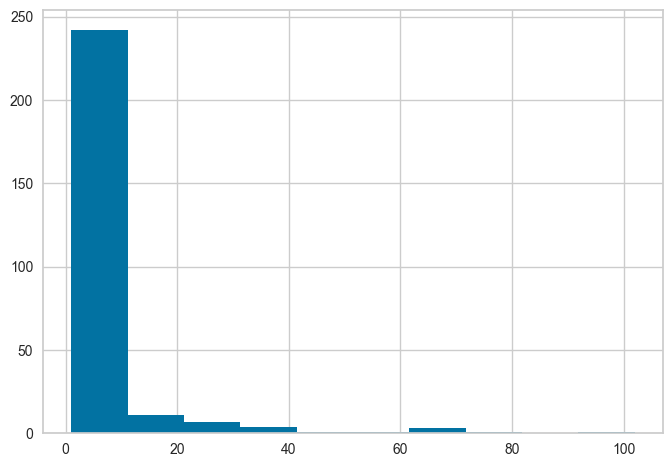

In [82]:
ocorrencias_tipos['qtd_ocorrencias'].hist()

In [84]:
fig = px.parallel_categories(ocorrencias_tipos[ocorrencias_tipos['qtd_ocorrencias']<=20], 
                             dimensions=['tipo_operacao','classificacao', 'tipo'],
                color="qtd_ocorrencias", color_continuous_scale=px.colors.sequential.Inferno,
                # labels={'sex':'Payer sex', 'smoker':'Smokers at the table', 'day':'Day of week'}
                )
fig.update_layout(
    height=1500,
    width=2000,
    title=dict(
        text=f"<b>Tipos de Acidentes/Incidentes por Operação e Classificação dos Danos</b>",
        x=0.5,
        y=0.95,
        font=dict(
            family="Arial",
            size=40,
            color='#000000'
        )
    ),
    xaxis_title=f"<b>Tipos</b>",
    yaxis_title='<b>Quant. Acidentes/Incidentes</b>',
    font=dict(
        family="Courier New, Monospace",
        size=20,
        color='#000000'
    ),
    xaxis={'categoryorder':'total descending'}
)
fig.show()

In [63]:
fig = px.histogram(df_ocorrencias_aeronave, x='tipo', nbins=100)
fig.update_layout(
    height=1100,
    width=2000,
    title=dict(
        text=f"<b>Frequência dos Tipos de Acidentes/Incidentes</b>",
        x=0.5,
        y=0.95,
        font=dict(
            family="Arial",
            size=40,
            color='#000000'
        )
    ),
    xaxis_title=f"<b>Tipos</b>",
    yaxis_title='<b>Quant. Acidentes/Incidentes</b>',
    font=dict(
        family="Courier New, Monospace",
        size=20,
        color='#000000'
    ),
    xaxis={'categoryorder':'total descending'}
)
fig.show()

In [59]:

fig = px.treemap(df_ocorrencias_aeronave.fillna('***'), path=['tipo_operacao','classificacao','tipo'], values='qtd_ocorrencias',
                  color='classificacao', 
                #   hover_data=['iso_alpha'],
                  color_continuous_scale='RdBu'
                  )

fig.update_layout(
        height=1500,
        width=2500,
        title=dict(
            text=f"<b> Relação entre os Tipos das Operações, Classificação dos Acidentes/Incidentes e Tipos dos Acidentes/Incidentes</b>",
            x=0.5,
            y=0.95,
            font=dict(
                family="Arial",
                size=40,
                color='#000000'
            )
        ),
       
        font=dict(
            family="Courier New, Monospace",
            size=20,
            color='#000000'
        ),
        xaxis={'categoryorder':'total descending'}
    )

fig.show()

#### Explorar data dos eventos 

Na intenção de avaliar a quantidade de acidentes aéreos em um determinado período de tempo e identificar se há uma tendência de aumento ou diminuição desses eventos. Considera-se a sazonalidade nos dados, ou seja, se há uma época do ano em que a ocorrência de acidentes é maior do que em outras.

Com base nessas informações, é possível criar modelos preditivos para antecipar possíveis cenários futuros e tomar ações preventivas. Por exemplo, se a análise de tendência mostrar um aumento na quantidade de acidentes aéreos em uma determinada região, pode-se implementar medidas de segurança adicionais ou reforçar a fiscalização nessas áreas para reduzir o risco de ocorrências futuras.

In [248]:
df_ocorrencias_aeronave.columns

Index(['codigo_aeronave', 'codigo_ocorrencia', 'matricula', 'codigo_operador', 'equipamento', 'fabricante', 'modelo', 'tipo_motor', 'quantidade_motores', 'peso_maximo_decolagem', 'quantidade_assentos', 'ano_fabricacao', 'pais_registro', 'categoria_registro', 'categoria_aviacao', 'origem_voo', 'destino_voo', 'fase_operacao', 'tipo_operacao', 'nivel_dano', 'quantidade_fatalidades', 'dia_extracao_x', 'classificacao', 'tipo', 'localidade', 'uf', 'pais', 'aerodromo', 'dia_ocorrencia', 'horario', 'sera_investigada', 'comando_investigador', 'status_investigacao', 'numero_relatorio', 'relatorio_publicado', 'dia_publicacao', 'quantidade_recomendacoes', 'aeronaves_envolvidas', 'saida_pista', 'dia_extracao_y'], dtype='object')

In [310]:

df_ocorrencias_aeronave['mes_ocorrencia'] = pd.to_datetime(df_ocorrencias_aeronave['dia_ocorrencia']).dt.to_period('M').astype(str)
df_ocorrencias_aeronave['quinzenal_ocorrencia'] = pd.to_datetime(df_ocorrencias_aeronave['dia_ocorrencia'])+ pd.offsets.SemiMonthEnd()
df_ocorrencias_aeronave['semana_ocorrencia'] = pd.to_datetime(df_ocorrencias_aeronave['dia_ocorrencia']).dt.to_period('W').astype(str)
df_ocorrencias_aeronave['anual_ocorrencia'] = pd.to_datetime(df_ocorrencias_aeronave['dia_ocorrencia']).dt.to_period('A').astype(str)
df_ocorrencias_aeronave['trimestre_ocorrencia'] = pd.to_datetime(df_ocorrencias_aeronave['dia_ocorrencia']).dt.to_period("Q").astype(str)

In [314]:
quantidade_eventos_data = df_ocorrencias_aeronave.groupby(['anual_ocorrencia'],as_index=False)['horario'].count()
quantidade_eventos_data.rename(columns={'horario':'qtd_eventos'},inplace=True)
fig = px.line(quantidade_eventos_data, x="anual_ocorrencia", y="qtd_eventos")#, color='uf')
fig.show()

In [315]:
quantidade_eventos_data = df_ocorrencias_aeronave.groupby(['trimestre_ocorrencia'],as_index=False)['horario'].count()
quantidade_eventos_data.rename(columns={'horario':'qtd_eventos'},inplace=True)
quantidade_eventos_data['mean']=quantidade_eventos_data['qtd_eventos'].rolling(15).mean()
fig = px.line(quantidade_eventos_data, x="trimestre_ocorrencia", y=["qtd_eventos",'mean'])#, color='uf')
fig.show()

In [316]:
quantidade_eventos_data = df_ocorrencias_aeronave.groupby(['mes_ocorrencia'],as_index=False)['horario'].count()
quantidade_eventos_data.rename(columns={'horario':'qtd_eventos'},inplace=True)
quantidade_eventos_data['mean']=quantidade_eventos_data['qtd_eventos'].rolling(15).mean()
fig = px.line(quantidade_eventos_data, x="mes_ocorrencia", y=["qtd_eventos",'mean'])#, color='uf')
fig.show()

In [317]:
quantidade_eventos_data = df_ocorrencias_aeronave.groupby(['quinzenal_ocorrencia'],as_index=False)['horario'].count()
quantidade_eventos_data.rename(columns={'horario':'qtd_eventos'},inplace=True)
quantidade_eventos_data['mean']=quantidade_eventos_data['qtd_eventos'].rolling(10).mean()
fig = px.line(quantidade_eventos_data, x="quinzenal_ocorrencia", y=["qtd_eventos",'mean'])#, color='uf')
fig.show()

In [318]:
quantidade_eventos_data = df_ocorrencias_aeronave.groupby(['semana_ocorrencia'],as_index=False)['horario'].count()
quantidade_eventos_data.rename(columns={'horario':'qtd_eventos'},inplace=True)
quantidade_eventos_data['mean']=quantidade_eventos_data['qtd_eventos'].rolling(15).mean()
fig = px.line(quantidade_eventos_data, x="semana_ocorrencia", y=["qtd_eventos",'mean'])#, color='uf')
fig.show()

Atraves dos gráficos é possivel observar uma tendencia de aumento de ocorrências nos meses de novembro a janeiro, dessa forma é possivel indicar ações preventivas para conter esses aumentos.

Também é observado uma tendencia de aumento de ocorrencias de 2008 a 2013 e um decaimento até 2015. A redução nos últimos 2 anos pode ser devido a alguma politica preventiva, caso não exista é indicado entender o motivo da diminuição na intenção de que a mesma continue a diminuir.